# Parte 2: Clasificación con RNR - LSTM

Arquitectura a usar con una RNN para clasificación :

    1- Sequence Input
    2- LSTM
    3- Fully-connected layer
    4- Softmax
    5- Classification output
    
Most LSTM/RNN diagrams just show the hidden cells but never the units of those cells. Hence, the confusion. Each hidden layer has hidden cells, as many as the number of time steps. And further, each hidden cell is made up of multiple hidden units, like in the diagram below. Therefore, the dimensionality of a hidden layer matrix in RNN is (number of time steps, number of hidden units). (https://datascience.stackexchange.com/questions/12964/what-is-the-meaning-of-the-number-of-units-in-the-lstm-cell ) 

-----
Teníamos: 
Observamos overfitting en la gráfica. Además:
    
    loss = 0.01
    accuracy = 0.999 
    val_loss = 2.09
    val_accuracy = 0.68
    
Por tanto: 

    Etrain = 1-0.999 = 0.001
    Etest = 1- 0.68 = 0.32
    
    Bias = Etrain - Ehuman = 0.001
    Variance = Etest - Etrain = 0.32 - 0.001 = 0.31
La varianza es alta, debemos tratar de reducirla: añadiendo más datos, regularizando, probando una arquitectura diferente...

-----
Ahora:

Añadimos kernel_initializer="he_normal", también rate_dropout = [0.8, 0.5, 0.3] (antiguo [0.8, 0.4, 0.2]), pasamos de n_neurons_per_hlayer = [75, 50 , 20] a n_neurons_per_hlayer = [75, 20] y  rate_dropout = [0.8, 0.3]para reducir la varianza. 

Seguimos observamos overfitting pero vemos una mejora en el accuracy, aunque 
			
    loss = 0.018446
    accuracy = 0.997468
    val_loss = 2.364552
    val_accuracy = 0.667401
    
Por tanto: 

    Etrain = 1-0.997468 = 0.002532
    Etest = 1- 0.667401 = 0.332599
    
    Bias = Etrain - Ehuman = 0.002532
    Variance = Etest - Etrain =0.332599 - 0.002532 = 0.31    

### 1 - Import Libraries

In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


### 2 - Load data

In [2]:
class ROutput:
    def __init__(self, task, data):
        self.task = task
        self.data = data
        
class OutTaskData: 
    def __init__(self, task, data): 
        self.task = task
        self.data = data

In [3]:
import scipy.io as sio
# Primero leemos los registros
def read_outputs(rec):
    '''read_outputs("userS0091f1.mat")'''
    mat = sio.loadmat(rec)
    #mdata = mat['output']
    #val = mdata[0,0]
    #output = ROutput(np.array(val["task"]), np.array(val["data"]))
    output = ROutput(np.array(mat["task"]), np.array(mat["data"]))
    return output

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron

total_records = 4 # CAMBIAR SI HAY MAS REGISTROS

task1 = 122 # SE PUEDE CAMBIAR
task2 = 123 # SE PUEDE CAMBIAR
task3 = 127 # SE PUEDE CAMBIAR
user = '0091' # SE PUEDE CAMBIAR

lTaskData = []
for i_rec in range(1,total_records+1):
        record = "userS"+user+"f"+str(i_rec)+".mat"
        output = read_outputs(record) # output.task será y, output.data será x
        
        if task3 != "":
            outT = (output.task == task1) | (output.task == task2) | (output.task == task3) 
        else: 
            outT = (output.task == task1) | (output.task == task2)
        outData = output.data[outT[:,0],0:np.shape(output.data)[1]]
        
        outTask = output.task[outT[:,0]]
        outTD = OutTaskData(outTask, outData)
        lTaskData.append(outTD)

# Vamos a coger 2 registros para el entrenamiento, 1 para el conjunto dev set, 1 para el test set
X_train, y_train, X_dev, y_dev = [],[],[],[] 
for j in range(0,total_records-2): # Cogemos 2 registros para entrenamiento
    X_train.extend(lTaskData[j].data)
    y_train.extend(lTaskData[j].task)
    
X_dev.extend(lTaskData[total_records-2].data) # Cogemos un registro para el dev set
y_dev.extend(lTaskData[total_records-2].task)

X_train = np.array(X_train)
y_train = np.ravel(np.array(y_train))
X_dev = np.array(X_dev)
y_dev = np.ravel(np.array(y_dev))

print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)

print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)

# ONE HOT ENCODER
encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
y_one_hot = np.concatenate((y_train, y_dev), axis=0)
y_one_hot = encoder.fit_transform (y_one_hot.reshape(-1,1))
y_train = y_one_hot[:np.shape(y_train)[0]]
y_dev = y_one_hot[np.shape(y_train)[0]:]

print("ONE HOT ENCODER:")
print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)

print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)


X_test, y_test = [],[]
X_test.extend(lTaskData[total_records-1].data) # Cogemos un registro para el test set
y_test.extend(lTaskData[total_records-1].task)


X_test = np.array(X_test)
y_test = np.ravel(np.array(y_test))
print()
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)

# ONE HOT ENCODER
encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
y_test = encoder.fit_transform (y_test.reshape(-1,1)) # y_one_hot

print("ONE HOT ENCODER:")
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)

X_train: (1837, 96)
y_train: (1837,)
X_dev: (928, 96)
y_dev: (928,)
ONE HOT ENCODER:
X_train: (1837, 96)
y_train: (1837, 3)
X_dev: (928, 96)
y_dev: (928, 3)

X_test: (908, 96)
y_test: (908,)
ONE HOT ENCODER:
X_test: (908, 96)
y_test: (908, 3)


Inputs needs to be reshaped to be [samples, time steps, features]

In [5]:
X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_dev = np.reshape(X_dev, (X_dev.shape[0],1, X_dev.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

y_train = np.reshape(y_train, (y_train.shape[0],1, y_train.shape[1]))
y_dev = np.reshape(y_dev, (y_dev.shape[0],1, y_dev.shape[1])) 
y_test = np.reshape(y_test, (y_test.shape[0],1, y_test.shape[1])) 

print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)

print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)

print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)

X_train: (1837, 1, 96)
y_train: (1837, 1, 3)
X_dev: (928, 1, 96)
y_dev: (928, 1, 3)
X_test: (908, 1, 96)
y_test: (908, 1, 3)


### 3. Initialize variables

In [6]:
INPUTS = X_train.shape[2]
OUTPUTS = y_train.shape[2]
print("INPUTS :", INPUTS)
print("OUTPUTS :", OUTPUTS)
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(y_train.shape[0]/1))

INPUTS : 96
OUTPUTS : 3


Some data is displayed to test correctness:

In [7]:
X_train[:2]

array([[[0.04408895, 0.12253977, 0.04091295, 0.08794782, 0.15217319,
         0.13608194, 0.2390196 , 0.13782482, 0.09390321, 0.04168143,
         0.01182343, 0.06681896, 0.22746509, 0.19109141, 0.12382088,
         0.16280571, 0.18183189, 0.03489224, 0.08915041, 0.25065591,
         0.05125344, 0.00878363, 0.06399049, 0.01269724, 0.37617251,
         0.75052793, 1.22515657, 0.34716337, 0.57574146, 0.22845317,
         0.29124432, 1.55810067, 0.17399072, 0.23187383, 0.09419699,
         0.06491878, 0.21030758, 0.11561159, 0.00684065, 0.05363316,
         0.14742724, 0.20516924, 0.16582891, 0.39129693, 0.01763402,
         0.05230747, 0.08436656, 0.05071257, 0.56726584, 0.21727165,
         0.5006733 , 0.09225466, 0.35750867, 0.43229655, 0.32666971,
         1.18042048, 0.04529925, 0.07339755, 0.12920241, 0.0228346 ,
         0.65176526, 0.09837585, 0.10240039, 0.35185881, 0.26348807,
         1.00112018, 0.61259061, 0.26154294, 0.2272173 , 0.11858029,
         0.23408875, 0.139735  , 0

In [8]:
X_dev[:2]

array([[[0.31977337, 0.34138627, 0.05036713, 0.01260456, 0.0353549 ,
         0.1185597 , 0.0467738 , 0.02048903, 0.11750225, 0.18469527,
         0.07158117, 0.04380819, 0.12918097, 0.15723066, 0.02486799,
         0.03569243, 0.13103253, 0.06666701, 0.12041935, 0.114042  ,
         0.01127984, 0.00650994, 0.05578655, 0.03110349, 1.27905692,
         0.72867136, 0.16631234, 0.39783501, 0.3504427 , 0.14931918,
         0.27219299, 0.119918  , 0.26639091, 0.05500265, 0.22028407,
         0.02976071, 0.49903653, 0.47147668, 0.21772425, 0.09625628,
         0.07949809, 0.07850754, 0.11222314, 0.0312656 , 0.0638701 ,
         0.01024857, 0.20098298, 0.12413927, 0.7959434 , 0.33244281,
         0.10382577, 0.36052956, 0.10868066, 0.25468323, 0.25108932,
         0.10744763, 0.22111074, 0.06949752, 0.22837273, 0.09663771,
         2.78278246, 0.95993224, 0.68951591, 0.5680906 , 0.29189192,
         0.02141107, 0.20762499, 0.11463274, 0.26281785, 0.02967406,
         0.25185108, 0.18281109, 1

In [9]:
y_train[:2]

array([[[0., 0., 1.]],

       [[0., 0., 1.]]])

In [10]:
y_dev[:2]

array([[[0., 1., 0.]],

       [[0., 1., 0.]]])

### 4 - Set hyperparameters

In [11]:
n_epochs = 2000
learning_rate = 0.001
batch_size = 250 
n_neurons_per_hlayer = [75, 50 , 20, 10] # Number of units per layer, 4 hidden layers
rate_dropout = [0.5, 0.3, 0.2, 0.1] 

### 5 - Build the model: 

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. 


nº de neuronas, capas, etc: https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm 

In [12]:
model = keras.Sequential(name="LSTM_classification")

model.add(keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True)) # , return_sequences = True
model.add(keras.layers.LSTM(100, return_sequences = True))
i = 0

for neurons in n_neurons_per_hlayer:
    model.add(keras.layers.Dense(neurons, activation="relu", kernel_initializer="he_normal"))
    
    model.add(keras.layers.Dropout(rate = rate_dropout[i]))
    model.add(keras.layers.BatchNormalization())
    i+=1

model.add(keras.layers.Dense(OUTPUTS, activation="softmax"))
model.summary()

Model: "LSTM_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 100)            78800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
dense (Dense)                (None, 1, 75)             7575      
_________________________________________________________________
dropout (Dropout)            (None, 1, 75)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 75)             300       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 50)             3800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)     

In [13]:
model.layers

In [14]:
for l in model.layers: print (l.name)

lstm
lstm_1
dense
dropout
batch_normalization
dense_1
dropout_1
batch_normalization_1
dense_2
dropout_2
batch_normalization_2
dense_3
dropout_3
batch_normalization_3
dense_4


All the parameters of a layer can bee accessed:

In [15]:
weightsC, weightsH, biases = model.layers[0].get_weights()
weightsH.shape

(100, 400)

In [16]:
weightsH

array([[-0.02236807, -0.03312656,  0.05610429, ..., -0.02381049,
         0.03009054, -0.0124248 ],
       [ 0.08578077,  0.03925169, -0.06620125, ..., -0.04166378,
        -0.02868706, -0.04424069],
       [ 0.05780238, -0.03759927, -0.02145195, ..., -0.01665606,
         0.04020085, -0.01746419],
       ...,
       [ 0.00629407, -0.06763437,  0.02092123, ..., -0.00371556,
        -0.04412926,  0.04521035],
       [-0.0566976 , -0.03733884, -0.04784728, ...,  0.00785759,
         0.07987204, -0.01387038],
       [ 0.05071673,  0.08995454,  0.0091143 , ...,  0.01061304,
        -0.01277154,  0.05684213]], dtype=float32)

In [17]:
biases # Bias de la primera capa: 500 bias inicializados a 0 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [18]:
biases.shape

(400,)

### 6. Compile the model

In [19]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999),
              metrics=["categorical_accuracy"])


In [20]:
X_train.shape

(1837, 1, 96)

### 7. Train the model with M-BGD

In [21]:
import time
start = time.time()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(X_dev, y_dev))    
print (time.time() - start)

Epoch 1/2000
8/8 [==============================] - 6s 229ms/step - loss: 1.3121 - categorical_accuracy: 0.3563 - val_loss: 1.0920 - val_categorical_accuracy: 0.4246
Epoch 2/2000
8/8 [==============================] - 0s 16ms/step - loss: 1.1893 - categorical_accuracy: 0.4106 - val_loss: 1.0980 - val_categorical_accuracy: 0.3190
Epoch 3/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.1114 - categorical_accuracy: 0.4488 - val_loss: 1.0980 - val_categorical_accuracy: 0.3006
Epoch 4/2000
8/8 [==============================] - 0s 19ms/step - loss: 1.0275 - categorical_accuracy: 0.4832 - val_loss: 1.0974 - val_categorical_accuracy: 0.2909
Epoch 5/2000
8/8 [==============================] - 0s 14ms/step - loss: 1.0301 - categorical_accuracy: 0.4940 - val_loss: 1.0955 - val_categorical_accuracy: 0.3006
Epoch 6/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.9797 - categorical_accuracy: 0.5224 - val_loss: 1.0932 - val_categorical_accuracy: 0.3157
Epoch 7/2

8/8 [==============================] - 0s 12ms/step - loss: 0.4879 - categorical_accuracy: 0.8244 - val_loss: 0.8592 - val_categorical_accuracy: 0.6509
Epoch 51/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.4545 - categorical_accuracy: 0.8319 - val_loss: 0.9158 - val_categorical_accuracy: 0.6239
Epoch 52/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.4525 - categorical_accuracy: 0.8261 - val_loss: 0.9684 - val_categorical_accuracy: 0.5765
Epoch 53/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.4552 - categorical_accuracy: 0.8319 - val_loss: 0.8465 - val_categorical_accuracy: 0.6595
Epoch 54/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.4333 - categorical_accuracy: 0.8397 - val_loss: 0.8898 - val_categorical_accuracy: 0.6498
Epoch 55/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.4484 - categorical_accuracy: 0.8335 - val_loss: 0.9309 - val_categorical_accuracy: 0.6261
Epoch 56/2000
8/8 

8/8 [==============================] - 0s 11ms/step - loss: 0.2232 - categorical_accuracy: 0.9276 - val_loss: 1.3204 - val_categorical_accuracy: 0.6638
Epoch 100/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2415 - categorical_accuracy: 0.9194 - val_loss: 1.7819 - val_categorical_accuracy: 0.6239
Epoch 101/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.2140 - categorical_accuracy: 0.9372 - val_loss: 1.3347 - val_categorical_accuracy: 0.6810
Epoch 102/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.2578 - categorical_accuracy: 0.9065 - val_loss: 1.4110 - val_categorical_accuracy: 0.6789
Epoch 103/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.2300 - categorical_accuracy: 0.9206 - val_loss: 1.4403 - val_categorical_accuracy: 0.6907
Epoch 104/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2037 - categorical_accuracy: 0.9362 - val_loss: 1.4188 - val_categorical_accuracy: 0.6627
Epoch 105/200

8/8 [==============================] - 0s 12ms/step - loss: 0.1028 - categorical_accuracy: 0.9700 - val_loss: 1.7796 - val_categorical_accuracy: 0.6379
Epoch 149/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1091 - categorical_accuracy: 0.9667 - val_loss: 2.3673 - val_categorical_accuracy: 0.6164
Epoch 150/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1085 - categorical_accuracy: 0.9721 - val_loss: 2.0202 - val_categorical_accuracy: 0.6369
Epoch 151/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1085 - categorical_accuracy: 0.9716 - val_loss: 2.0629 - val_categorical_accuracy: 0.6541
Epoch 152/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0947 - categorical_accuracy: 0.9694 - val_loss: 1.9358 - val_categorical_accuracy: 0.6735
Epoch 153/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0940 - categorical_accuracy: 0.9707 - val_loss: 1.8343 - val_categorical_accuracy: 0.6746
Epoch 154/200

8/8 [==============================] - 0s 10ms/step - loss: 0.0741 - categorical_accuracy: 0.9762 - val_loss: 2.6117 - val_categorical_accuracy: 0.6131
Epoch 198/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0726 - categorical_accuracy: 0.9796 - val_loss: 2.4349 - val_categorical_accuracy: 0.6422
Epoch 199/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0694 - categorical_accuracy: 0.9789 - val_loss: 2.2952 - val_categorical_accuracy: 0.6099
Epoch 200/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0493 - categorical_accuracy: 0.9865 - val_loss: 2.4891 - val_categorical_accuracy: 0.6282
Epoch 201/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0582 - categorical_accuracy: 0.9863 - val_loss: 2.2806 - val_categorical_accuracy: 0.6509
Epoch 202/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0492 - categorical_accuracy: 0.9836 - val_loss: 2.3127 - val_categorical_accuracy: 0.6595
Epoch 203/200

8/8 [==============================] - 0s 16ms/step - loss: 0.0300 - categorical_accuracy: 0.9932 - val_loss: 2.9532 - val_categorical_accuracy: 0.5797
Epoch 247/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0391 - categorical_accuracy: 0.9891 - val_loss: 2.5491 - val_categorical_accuracy: 0.6282
Epoch 248/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0237 - categorical_accuracy: 0.9923 - val_loss: 2.7291 - val_categorical_accuracy: 0.6541
Epoch 249/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0490 - categorical_accuracy: 0.9853 - val_loss: 2.8879 - val_categorical_accuracy: 0.6078
Epoch 250/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0261 - categorical_accuracy: 0.9956 - val_loss: 2.9139 - val_categorical_accuracy: 0.6142
Epoch 251/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0333 - categorical_accuracy: 0.9886 - val_loss: 3.1305 - val_categorical_accuracy: 0.5981
Epoch 252/200

8/8 [==============================] - 0s 11ms/step - loss: 0.0191 - categorical_accuracy: 0.9957 - val_loss: 2.5165 - val_categorical_accuracy: 0.6756
Epoch 296/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0342 - categorical_accuracy: 0.9907 - val_loss: 2.7766 - val_categorical_accuracy: 0.6466
Epoch 297/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0311 - categorical_accuracy: 0.9895 - val_loss: 2.7743 - val_categorical_accuracy: 0.6228
Epoch 298/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0295 - categorical_accuracy: 0.9920 - val_loss: 3.5308 - val_categorical_accuracy: 0.5959
Epoch 299/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0621 - categorical_accuracy: 0.9840 - val_loss: 2.7698 - val_categorical_accuracy: 0.6304
Epoch 300/2000
8/8 [==============================] - 0s 17ms/step - loss: 0.0552 - categorical_accuracy: 0.9847 - val_loss: 3.2282 - val_categorical_accuracy: 0.6099
Epoch 301/200

8/8 [==============================] - 0s 12ms/step - loss: 0.0137 - categorical_accuracy: 0.9971 - val_loss: 3.1883 - val_categorical_accuracy: 0.6358
Epoch 345/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0099 - categorical_accuracy: 0.9987 - val_loss: 2.8794 - val_categorical_accuracy: 0.6519
Epoch 346/2000
8/8 [==============================] - 0s 19ms/step - loss: 0.0225 - categorical_accuracy: 0.9939 - val_loss: 2.9821 - val_categorical_accuracy: 0.6562
Epoch 347/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0218 - categorical_accuracy: 0.9949 - val_loss: 3.2174 - val_categorical_accuracy: 0.6530
Epoch 348/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0181 - categorical_accuracy: 0.9932 - val_loss: 3.5388 - val_categorical_accuracy: 0.6175
Epoch 349/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0297 - categorical_accuracy: 0.9922 - val_loss: 3.2175 - val_categorical_accuracy: 0.6498
Epoch 350/200

8/8 [==============================] - 0s 14ms/step - loss: 0.0152 - categorical_accuracy: 0.9966 - val_loss: 3.2128 - val_categorical_accuracy: 0.6272
Epoch 394/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0162 - categorical_accuracy: 0.9948 - val_loss: 3.2489 - val_categorical_accuracy: 0.6121
Epoch 395/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0111 - categorical_accuracy: 0.9982 - val_loss: 3.2720 - val_categorical_accuracy: 0.6185
Epoch 396/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0081 - categorical_accuracy: 0.9987 - val_loss: 3.2477 - val_categorical_accuracy: 0.6390
Epoch 397/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0105 - categorical_accuracy: 0.9969 - val_loss: 3.0936 - val_categorical_accuracy: 0.6552
Epoch 398/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0120 - categorical_accuracy: 0.9967 - val_loss: 3.3713 - val_categorical_accuracy: 0.6304
Epoch 399/200

8/8 [==============================] - 0s 12ms/step - loss: 0.0576 - categorical_accuracy: 0.9864 - val_loss: 3.9725 - val_categorical_accuracy: 0.6056
Epoch 443/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0457 - categorical_accuracy: 0.9883 - val_loss: 3.6157 - val_categorical_accuracy: 0.6315
Epoch 444/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0362 - categorical_accuracy: 0.9917 - val_loss: 3.7572 - val_categorical_accuracy: 0.6218
Epoch 445/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0413 - categorical_accuracy: 0.9902 - val_loss: 3.0780 - val_categorical_accuracy: 0.6530
Epoch 446/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0679 - categorical_accuracy: 0.9866 - val_loss: 3.1486 - val_categorical_accuracy: 0.6573
Epoch 447/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0302 - categorical_accuracy: 0.9929 - val_loss: 3.1425 - val_categorical_accuracy: 0.6325
Epoch 448/200

8/8 [==============================] - 0s 12ms/step - loss: 0.0117 - categorical_accuracy: 0.9953 - val_loss: 3.3850 - val_categorical_accuracy: 0.6315
Epoch 492/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0426 - categorical_accuracy: 0.9865 - val_loss: 3.4860 - val_categorical_accuracy: 0.6088
Epoch 493/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0278 - categorical_accuracy: 0.9904 - val_loss: 2.8601 - val_categorical_accuracy: 0.6530
Epoch 494/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0085 - categorical_accuracy: 0.9981 - val_loss: 2.9111 - val_categorical_accuracy: 0.6703
Epoch 495/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0250 - categorical_accuracy: 0.9923 - val_loss: 3.4450 - val_categorical_accuracy: 0.6239
Epoch 496/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0207 - categorical_accuracy: 0.9943 - val_loss: 2.7589 - val_categorical_accuracy: 0.6584
Epoch 497/200

8/8 [==============================] - 0s 13ms/step - loss: 0.0234 - categorical_accuracy: 0.9940 - val_loss: 3.9187 - val_categorical_accuracy: 0.6325
Epoch 541/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0222 - categorical_accuracy: 0.9945 - val_loss: 3.3880 - val_categorical_accuracy: 0.6444
Epoch 542/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0390 - categorical_accuracy: 0.9884 - val_loss: 3.1432 - val_categorical_accuracy: 0.6713
Epoch 543/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0222 - categorical_accuracy: 0.9944 - val_loss: 3.4674 - val_categorical_accuracy: 0.6422
Epoch 544/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0289 - categorical_accuracy: 0.9915 - val_loss: 3.1499 - val_categorical_accuracy: 0.6746
Epoch 545/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0348 - categorical_accuracy: 0.9932 - val_loss: 2.9792 - val_categorical_accuracy: 0.6659
Epoch 546/200

8/8 [==============================] - 0s 13ms/step - loss: 0.0065 - categorical_accuracy: 0.9987 - val_loss: 3.1883 - val_categorical_accuracy: 0.6573
Epoch 590/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0105 - categorical_accuracy: 0.9983 - val_loss: 3.0783 - val_categorical_accuracy: 0.6390
Epoch 591/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0073 - categorical_accuracy: 0.9976 - val_loss: 3.2450 - val_categorical_accuracy: 0.6207
Epoch 592/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0082 - categorical_accuracy: 0.9979 - val_loss: 3.0241 - val_categorical_accuracy: 0.6476
Epoch 593/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0059 - categorical_accuracy: 0.9988 - val_loss: 3.0638 - val_categorical_accuracy: 0.6584
Epoch 594/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0089 - categorical_accuracy: 0.9991 - val_loss: 3.1528 - val_categorical_accuracy: 0.6552
Epoch 595/200

8/8 [==============================] - 0s 12ms/step - loss: 0.0286 - categorical_accuracy: 0.9930 - val_loss: 3.2998 - val_categorical_accuracy: 0.6552
Epoch 639/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0317 - categorical_accuracy: 0.9914 - val_loss: 3.2488 - val_categorical_accuracy: 0.6509
Epoch 640/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0245 - categorical_accuracy: 0.9938 - val_loss: 3.7864 - val_categorical_accuracy: 0.6250
Epoch 641/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0157 - categorical_accuracy: 0.9941 - val_loss: 3.0936 - val_categorical_accuracy: 0.6670
Epoch 642/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0218 - categorical_accuracy: 0.9934 - val_loss: 3.1855 - val_categorical_accuracy: 0.6584
Epoch 643/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0135 - categorical_accuracy: 0.9954 - val_loss: 3.2700 - val_categorical_accuracy: 0.6476
Epoch 644/200

8/8 [==============================] - 0s 11ms/step - loss: 0.0104 - categorical_accuracy: 0.9982 - val_loss: 3.3409 - val_categorical_accuracy: 0.6810
Epoch 687/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0380 - categorical_accuracy: 0.9898 - val_loss: 3.7268 - val_categorical_accuracy: 0.6261
Epoch 688/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0337 - categorical_accuracy: 0.9918 - val_loss: 3.2984 - val_categorical_accuracy: 0.6562
Epoch 689/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0537 - categorical_accuracy: 0.9877 - val_loss: 3.1617 - val_categorical_accuracy: 0.6638
Epoch 690/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0440 - categorical_accuracy: 0.9901 - val_loss: 3.8721 - val_categorical_accuracy: 0.6390
Epoch 691/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0436 - categorical_accuracy: 0.9912 - val_loss: 3.5421 - val_categorical_accuracy: 0.6530
Epoch 692/200

8/8 [==============================] - 0s 12ms/step - loss: 0.0718 - categorical_accuracy: 0.9815 - val_loss: 3.2569 - val_categorical_accuracy: 0.6379
Epoch 736/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0235 - categorical_accuracy: 0.9964 - val_loss: 2.9690 - val_categorical_accuracy: 0.6358
Epoch 737/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0343 - categorical_accuracy: 0.9917 - val_loss: 3.5302 - val_categorical_accuracy: 0.6164
Epoch 738/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0369 - categorical_accuracy: 0.9897 - val_loss: 2.8620 - val_categorical_accuracy: 0.6670
Epoch 739/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0512 - categorical_accuracy: 0.9916 - val_loss: 2.8363 - val_categorical_accuracy: 0.6573
Epoch 740/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0204 - categorical_accuracy: 0.9964 - val_loss: 3.1064 - val_categorical_accuracy: 0.6476
Epoch 741/200

8/8 [==============================] - 0s 11ms/step - loss: 0.0034 - categorical_accuracy: 0.9992 - val_loss: 3.8768 - val_categorical_accuracy: 0.6272
Epoch 785/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0043 - categorical_accuracy: 0.9989 - val_loss: 3.8558 - val_categorical_accuracy: 0.6196
Epoch 786/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0245 - categorical_accuracy: 0.9950 - val_loss: 3.8678 - val_categorical_accuracy: 0.6325
Epoch 787/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0117 - categorical_accuracy: 0.9956 - val_loss: 3.4213 - val_categorical_accuracy: 0.6649
Epoch 788/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0180 - categorical_accuracy: 0.9957 - val_loss: 4.1979 - val_categorical_accuracy: 0.6250
Epoch 789/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0144 - categorical_accuracy: 0.9955 - val_loss: 4.4348 - val_categorical_accuracy: 0.5938
Epoch 790/200

8/8 [==============================] - 0s 11ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 3.7077 - val_categorical_accuracy: 0.6412
Epoch 834/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0042 - categorical_accuracy: 0.9980 - val_loss: 3.7372 - val_categorical_accuracy: 0.6379
Epoch 835/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0064 - categorical_accuracy: 0.9985 - val_loss: 3.5019 - val_categorical_accuracy: 0.6681
Epoch 836/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0042 - categorical_accuracy: 0.9983 - val_loss: 3.4726 - val_categorical_accuracy: 0.6703
Epoch 837/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0023 - categorical_accuracy: 0.9999 - val_loss: 3.5970 - val_categorical_accuracy: 0.6552
Epoch 838/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 4.1504 - val_categorical_accuracy: 0.6121
Epoch 839/200

8/8 [==============================] - 0s 11ms/step - loss: 0.0220 - categorical_accuracy: 0.9953 - val_loss: 3.2460 - val_categorical_accuracy: 0.6336
Epoch 883/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0186 - categorical_accuracy: 0.9961 - val_loss: 3.3510 - val_categorical_accuracy: 0.6347
Epoch 884/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0148 - categorical_accuracy: 0.9961 - val_loss: 3.3319 - val_categorical_accuracy: 0.6541
Epoch 885/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0270 - categorical_accuracy: 0.9961 - val_loss: 3.7405 - val_categorical_accuracy: 0.5927
Epoch 886/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0345 - categorical_accuracy: 0.9907 - val_loss: 3.0466 - val_categorical_accuracy: 0.6466
Epoch 887/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0277 - categorical_accuracy: 0.9954 - val_loss: 3.1796 - val_categorical_accuracy: 0.6422
Epoch 888/200

8/8 [==============================] - 0s 11ms/step - loss: 0.0079 - categorical_accuracy: 0.9981 - val_loss: 3.6400 - val_categorical_accuracy: 0.6552
Epoch 932/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0038 - categorical_accuracy: 0.9990 - val_loss: 3.6110 - val_categorical_accuracy: 0.6606
Epoch 933/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0056 - categorical_accuracy: 0.9990 - val_loss: 3.6344 - val_categorical_accuracy: 0.6552
Epoch 934/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0022 - categorical_accuracy: 0.9995 - val_loss: 3.6881 - val_categorical_accuracy: 0.6487
Epoch 935/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0049 - categorical_accuracy: 0.9992 - val_loss: 3.8369 - val_categorical_accuracy: 0.6412
Epoch 936/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 3.8915 - val_categorical_accuracy: 0.6422
Epoch 937/200

8/8 [==============================] - 0s 11ms/step - loss: 0.0027 - categorical_accuracy: 0.9997 - val_loss: 3.9629 - val_categorical_accuracy: 0.6250
Epoch 981/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0037 - categorical_accuracy: 0.9984 - val_loss: 3.9925 - val_categorical_accuracy: 0.6207
Epoch 982/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0038 - categorical_accuracy: 0.9987 - val_loss: 3.7840 - val_categorical_accuracy: 0.6616
Epoch 983/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0108 - categorical_accuracy: 0.9983 - val_loss: 3.4763 - val_categorical_accuracy: 0.6606
Epoch 984/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0056 - categorical_accuracy: 0.9980 - val_loss: 3.5254 - val_categorical_accuracy: 0.6573
Epoch 985/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0030 - categorical_accuracy: 0.9996 - val_loss: 3.7006 - val_categorical_accuracy: 0.6530
Epoch 986/200

Epoch 1029/2000
8/8 [==============================] - 0s 17ms/step - loss: 0.0155 - categorical_accuracy: 0.9964 - val_loss: 3.8631 - val_categorical_accuracy: 0.6325
Epoch 1030/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0355 - categorical_accuracy: 0.9927 - val_loss: 3.5216 - val_categorical_accuracy: 0.6616
Epoch 1031/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0166 - categorical_accuracy: 0.9957 - val_loss: 3.2182 - val_categorical_accuracy: 0.6649
Epoch 1032/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0689 - categorical_accuracy: 0.9853 - val_loss: 4.3075 - val_categorical_accuracy: 0.6110
Epoch 1033/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0521 - categorical_accuracy: 0.9873 - val_loss: 3.4094 - val_categorical_accuracy: 0.6412
Epoch 1034/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0281 - categorical_accuracy: 0.9913 - val_loss: 2.8301 - val_categorical_accuracy:

Epoch 1078/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0020 - categorical_accuracy: 0.9996 - val_loss: 3.7368 - val_categorical_accuracy: 0.6552
Epoch 1079/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0033 - categorical_accuracy: 0.9987 - val_loss: 3.7732 - val_categorical_accuracy: 0.6552
Epoch 1080/2000
8/8 [==============================] - 0s 11ms/step - loss: 9.0366e-04 - categorical_accuracy: 1.0000 - val_loss: 3.8005 - val_categorical_accuracy: 0.6552
Epoch 1081/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 3.8250 - val_categorical_accuracy: 0.6530
Epoch 1082/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0021 - categorical_accuracy: 0.9997 - val_loss: 3.8426 - val_categorical_accuracy: 0.6541
Epoch 1083/2000
8/8 [==============================] - 0s 12ms/step - loss: 8.3927e-04 - categorical_accuracy: 1.0000 - val_loss: 3.8599 - val_categorical_a

8/8 [==============================] - 0s 11ms/step - loss: 0.0101 - categorical_accuracy: 0.9968 - val_loss: 3.5506 - val_categorical_accuracy: 0.6519
Epoch 1127/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0093 - categorical_accuracy: 0.9972 - val_loss: 3.7546 - val_categorical_accuracy: 0.6390
Epoch 1128/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0076 - categorical_accuracy: 0.9984 - val_loss: 3.9672 - val_categorical_accuracy: 0.6272
Epoch 1129/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0140 - categorical_accuracy: 0.9969 - val_loss: 3.8786 - val_categorical_accuracy: 0.6358
Epoch 1130/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0061 - categorical_accuracy: 0.9982 - val_loss: 3.5882 - val_categorical_accuracy: 0.6541
Epoch 1131/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0036 - categorical_accuracy: 0.9988 - val_loss: 3.5714 - val_categorical_accuracy: 0.6595
Epoch 11

Epoch 1175/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0020 - categorical_accuracy: 0.9994 - val_loss: 3.9941 - val_categorical_accuracy: 0.6606
Epoch 1176/2000
8/8 [==============================] - 0s 11ms/step - loss: 9.7105e-04 - categorical_accuracy: 1.0000 - val_loss: 3.9374 - val_categorical_accuracy: 0.6573
Epoch 1177/2000
8/8 [==============================] - 0s 11ms/step - loss: 8.7530e-04 - categorical_accuracy: 1.0000 - val_loss: 3.9632 - val_categorical_accuracy: 0.6573
Epoch 1178/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0018 - categorical_accuracy: 1.0000 - val_loss: 3.9812 - val_categorical_accuracy: 0.6519
Epoch 1179/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0051 - categorical_accuracy: 0.9981 - val_loss: 4.0025 - val_categorical_accuracy: 0.6487
Epoch 1180/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0045 - categorical_accuracy: 0.9995 - val_loss: 4.0992 - val_categorical_a

Epoch 1224/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0038 - categorical_accuracy: 0.9992 - val_loss: 3.5521 - val_categorical_accuracy: 0.6433
Epoch 1225/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0037 - categorical_accuracy: 0.9987 - val_loss: 3.5764 - val_categorical_accuracy: 0.6444
Epoch 1226/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0029 - categorical_accuracy: 1.0000 - val_loss: 3.5578 - val_categorical_accuracy: 0.6444
Epoch 1227/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0024 - categorical_accuracy: 0.9999 - val_loss: 3.5245 - val_categorical_accuracy: 0.6466
Epoch 1228/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0063 - categorical_accuracy: 0.9965 - val_loss: 3.4559 - val_categorical_accuracy: 0.6530
Epoch 1229/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 3.4497 - val_categorical_accuracy:

Epoch 1273/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 3.8508 - val_categorical_accuracy: 0.6595
Epoch 1274/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0027 - categorical_accuracy: 0.9985 - val_loss: 3.8538 - val_categorical_accuracy: 0.6606
Epoch 1275/2000
8/8 [==============================] - 0s 11ms/step - loss: 8.8984e-04 - categorical_accuracy: 1.0000 - val_loss: 3.8856 - val_categorical_accuracy: 0.6573
Epoch 1276/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0051 - categorical_accuracy: 0.9984 - val_loss: 3.8909 - val_categorical_accuracy: 0.6573
Epoch 1277/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 3.8973 - val_categorical_accuracy: 0.6573
Epoch 1278/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0022 - categorical_accuracy: 0.9987 - val_loss: 3.9057 - val_categorical_accur

8/8 [==============================] - 0s 14ms/step - loss: 0.0034 - categorical_accuracy: 0.9997 - val_loss: 3.5705 - val_categorical_accuracy: 0.6756
Epoch 1322/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0027 - categorical_accuracy: 1.0000 - val_loss: 3.7762 - val_categorical_accuracy: 0.6627
Epoch 1323/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0031 - categorical_accuracy: 0.9997 - val_loss: 3.7127 - val_categorical_accuracy: 0.6541
Epoch 1324/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0030 - categorical_accuracy: 0.9992 - val_loss: 3.4720 - val_categorical_accuracy: 0.6703
Epoch 1325/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0035 - categorical_accuracy: 0.9990 - val_loss: 3.5571 - val_categorical_accuracy: 0.6347
Epoch 1326/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0037 - categorical_accuracy: 0.9981 - val_loss: 3.5633 - val_categorical_accuracy: 0.6250
Epoch 13

Epoch 1370/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0035 - categorical_accuracy: 0.9981 - val_loss: 3.8442 - val_categorical_accuracy: 0.6530
Epoch 1371/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 3.8565 - val_categorical_accuracy: 0.6530
Epoch 1372/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0025 - categorical_accuracy: 0.9991 - val_loss: 3.8725 - val_categorical_accuracy: 0.6530
Epoch 1373/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0023 - categorical_accuracy: 1.0000 - val_loss: 3.8781 - val_categorical_accuracy: 0.6541
Epoch 1374/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 3.8928 - val_categorical_accuracy: 0.6541
Epoch 1375/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0038 - categorical_accuracy: 0.9995 - val_loss: 3.8873 - val_categorical_accuracy:

Epoch 1419/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0010 - categorical_accuracy: 0.9998 - val_loss: 3.8307 - val_categorical_accuracy: 0.6606
Epoch 1420/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0021 - categorical_accuracy: 0.9997 - val_loss: 3.8637 - val_categorical_accuracy: 0.6562
Epoch 1421/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0034 - categorical_accuracy: 0.9987 - val_loss: 3.8585 - val_categorical_accuracy: 0.6573
Epoch 1422/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0016 - categorical_accuracy: 0.9997 - val_loss: 3.8520 - val_categorical_accuracy: 0.6562
Epoch 1423/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0038 - categorical_accuracy: 0.9984 - val_loss: 3.9233 - val_categorical_accuracy: 0.6541
Epoch 1424/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0034 - categorical_accuracy: 0.9994 - val_loss: 4.0076 - val_categorical_accuracy:

Epoch 1468/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0028 - categorical_accuracy: 0.9987 - val_loss: 3.8925 - val_categorical_accuracy: 0.6369
Epoch 1469/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0024 - categorical_accuracy: 0.9994 - val_loss: 3.9295 - val_categorical_accuracy: 0.6336
Epoch 1470/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 4.0059 - val_categorical_accuracy: 0.6390
Epoch 1471/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 4.0457 - val_categorical_accuracy: 0.6379
Epoch 1472/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0023 - categorical_accuracy: 1.0000 - val_loss: 4.0685 - val_categorical_accuracy: 0.6336
Epoch 1473/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0029 - categorical_accuracy: 0.9993 - val_loss: 3.8351 - val_categorical_accuracy:

Epoch 1517/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0043 - categorical_accuracy: 0.9990 - val_loss: 4.6334 - val_categorical_accuracy: 0.5948
Epoch 1518/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0176 - categorical_accuracy: 0.9966 - val_loss: 3.9532 - val_categorical_accuracy: 0.6476
Epoch 1519/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0101 - categorical_accuracy: 0.9972 - val_loss: 4.7432 - val_categorical_accuracy: 0.6153
Epoch 1520/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0225 - categorical_accuracy: 0.9963 - val_loss: 3.7612 - val_categorical_accuracy: 0.6509
Epoch 1521/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0051 - categorical_accuracy: 0.9987 - val_loss: 3.5461 - val_categorical_accuracy: 0.6724
Epoch 1522/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 3.6568 - val_categorical_accuracy:

Epoch 1566/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0016 - categorical_accuracy: 0.9997 - val_loss: 3.9224 - val_categorical_accuracy: 0.6584
Epoch 1567/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0039 - categorical_accuracy: 0.9983 - val_loss: 4.0457 - val_categorical_accuracy: 0.6390
Epoch 1568/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 4.2422 - val_categorical_accuracy: 0.6336
Epoch 1569/2000
8/8 [==============================] - 0s 11ms/step - loss: 8.8519e-04 - categorical_accuracy: 1.0000 - val_loss: 4.3796 - val_categorical_accuracy: 0.6293
Epoch 1570/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0011 - categorical_accuracy: 0.9997 - val_loss: 4.4357 - val_categorical_accuracy: 0.6293
Epoch 1571/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0030 - categorical_accuracy: 0.9984 - val_loss: 4.3944 - val_categorical_accur

8/8 [==============================] - 0s 11ms/step - loss: 0.0014 - categorical_accuracy: 0.9997 - val_loss: 4.1504 - val_categorical_accuracy: 0.6444
Epoch 1615/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0051 - categorical_accuracy: 0.9983 - val_loss: 3.8695 - val_categorical_accuracy: 0.6573
Epoch 1616/2000
8/8 [==============================] - 0s 11ms/step - loss: 9.6023e-04 - categorical_accuracy: 1.0000 - val_loss: 3.8594 - val_categorical_accuracy: 0.6616
Epoch 1617/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0025 - categorical_accuracy: 0.9994 - val_loss: 3.8684 - val_categorical_accuracy: 0.6670
Epoch 1618/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0027 - categorical_accuracy: 0.9997 - val_loss: 4.0368 - val_categorical_accuracy: 0.6466
Epoch 1619/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0026 - categorical_accuracy: 1.0000 - val_loss: 4.3273 - val_categorical_accuracy: 0.6390
Epoc

Epoch 1663/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0014 - categorical_accuracy: 0.9999 - val_loss: 4.2082 - val_categorical_accuracy: 0.6412
Epoch 1664/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0011 - categorical_accuracy: 0.9997 - val_loss: 4.2018 - val_categorical_accuracy: 0.6422
Epoch 1665/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0027 - categorical_accuracy: 0.9997 - val_loss: 4.2093 - val_categorical_accuracy: 0.6412
Epoch 1666/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0034 - categorical_accuracy: 0.9997 - val_loss: 4.3102 - val_categorical_accuracy: 0.6390
Epoch 1667/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0020 - categorical_accuracy: 1.0000 - val_loss: 4.4151 - val_categorical_accuracy: 0.6379
Epoch 1668/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0013 - categorical_accuracy: 0.9998 - val_loss: 4.4292 - val_categorical_accuracy:

Epoch 1712/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0030 - categorical_accuracy: 0.9992 - val_loss: 3.9807 - val_categorical_accuracy: 0.6476
Epoch 1713/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0029 - categorical_accuracy: 0.9995 - val_loss: 3.9559 - val_categorical_accuracy: 0.6466
Epoch 1714/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0011 - categorical_accuracy: 0.9999 - val_loss: 4.1147 - val_categorical_accuracy: 0.6466
Epoch 1715/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0049 - categorical_accuracy: 0.9994 - val_loss: 4.5712 - val_categorical_accuracy: 0.6196
Epoch 1716/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 3.8153 - val_categorical_accuracy: 0.6649
Epoch 1717/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0038 - categorical_accuracy: 0.9987 - val_loss: 3.8595 - val_categorical_accuracy:

8/8 [==============================] - 0s 17ms/step - loss: 8.9883e-04 - categorical_accuracy: 1.0000 - val_loss: 4.3546 - val_categorical_accuracy: 0.6530
Epoch 1761/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0015 - categorical_accuracy: 0.9998 - val_loss: 4.3585 - val_categorical_accuracy: 0.6530
Epoch 1762/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0014 - categorical_accuracy: 0.9995 - val_loss: 4.3704 - val_categorical_accuracy: 0.6498
Epoch 1763/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0023 - categorical_accuracy: 0.9992 - val_loss: 4.4213 - val_categorical_accuracy: 0.6455
Epoch 1764/2000
8/8 [==============================] - 0s 16ms/step - loss: 6.8158e-04 - categorical_accuracy: 1.0000 - val_loss: 4.4427 - val_categorical_accuracy: 0.6444
Epoch 1765/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0015 - categorical_accuracy: 0.9999 - val_loss: 4.5136 - val_categorical_accuracy: 0.6498


8/8 [==============================] - 0s 18ms/step - loss: 0.0214 - categorical_accuracy: 0.9968 - val_loss: 4.7952 - val_categorical_accuracy: 0.6412
Epoch 1809/2000
8/8 [==============================] - 0s 17ms/step - loss: 0.0033 - categorical_accuracy: 0.9993 - val_loss: 4.5371 - val_categorical_accuracy: 0.6519
Epoch 1810/2000
8/8 [==============================] - 0s 19ms/step - loss: 0.0115 - categorical_accuracy: 0.9966 - val_loss: 5.0080 - val_categorical_accuracy: 0.6369
Epoch 1811/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0288 - categorical_accuracy: 0.9928 - val_loss: 4.2972 - val_categorical_accuracy: 0.6638
Epoch 1812/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0600 - categorical_accuracy: 0.9904 - val_loss: 4.2168 - val_categorical_accuracy: 0.6509
Epoch 1813/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0530 - categorical_accuracy: 0.9899 - val_loss: 3.5583 - val_categorical_accuracy: 0.6886
Epoch 18

8/8 [==============================] - 0s 17ms/step - loss: 0.0028 - categorical_accuracy: 0.9990 - val_loss: 4.3054 - val_categorical_accuracy: 0.6552
Epoch 1857/2000
8/8 [==============================] - 0s 16ms/step - loss: 7.3236e-04 - categorical_accuracy: 1.0000 - val_loss: 4.2911 - val_categorical_accuracy: 0.6519
Epoch 1858/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0012 - categorical_accuracy: 0.9998 - val_loss: 4.2834 - val_categorical_accuracy: 0.6519
Epoch 1859/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0024 - categorical_accuracy: 0.9986 - val_loss: 4.2678 - val_categorical_accuracy: 0.6541
Epoch 1860/2000
8/8 [==============================] - 0s 15ms/step - loss: 9.3886e-04 - categorical_accuracy: 1.0000 - val_loss: 4.2306 - val_categorical_accuracy: 0.6509
Epoch 1861/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0017 - categorical_accuracy: 0.9997 - val_loss: 4.2279 - val_categorical_accuracy: 0.6519


8/8 [==============================] - 0s 11ms/step - loss: 0.0011 - categorical_accuracy: 0.9997 - val_loss: 4.7859 - val_categorical_accuracy: 0.6336
Epoch 1905/2000
8/8 [==============================] - 0s 11ms/step - loss: 4.7696e-04 - categorical_accuracy: 1.0000 - val_loss: 4.7971 - val_categorical_accuracy: 0.6336
Epoch 1906/2000
8/8 [==============================] - 0s 11ms/step - loss: 7.9645e-04 - categorical_accuracy: 1.0000 - val_loss: 4.8047 - val_categorical_accuracy: 0.6336
Epoch 1907/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0016 - categorical_accuracy: 0.9992 - val_loss: 4.8022 - val_categorical_accuracy: 0.6336
Epoch 1908/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0051 - categorical_accuracy: 0.9971 - val_loss: 4.8065 - val_categorical_accuracy: 0.6347
Epoch 1909/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0015 - categorical_accuracy: 0.9994 - val_loss: 4.8093 - val_categorical_accuracy: 0.6347


8/8 [==============================] - 0s 14ms/step - loss: 0.0211 - categorical_accuracy: 0.9935 - val_loss: 4.4658 - val_categorical_accuracy: 0.6616
Epoch 1953/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.0323 - categorical_accuracy: 0.9927 - val_loss: 5.1911 - val_categorical_accuracy: 0.6379
Epoch 1954/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0325 - categorical_accuracy: 0.9928 - val_loss: 4.0568 - val_categorical_accuracy: 0.6692
Epoch 1955/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.0074 - categorical_accuracy: 0.9965 - val_loss: 4.6638 - val_categorical_accuracy: 0.6347
Epoch 1956/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.0284 - categorical_accuracy: 0.9932 - val_loss: 4.1088 - val_categorical_accuracy: 0.6552
Epoch 1957/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.0678 - categorical_accuracy: 0.9897 - val_loss: 4.4208 - val_categorical_accuracy: 0.6562
Epoch 19

196.12021446228027


### 8. Get the results

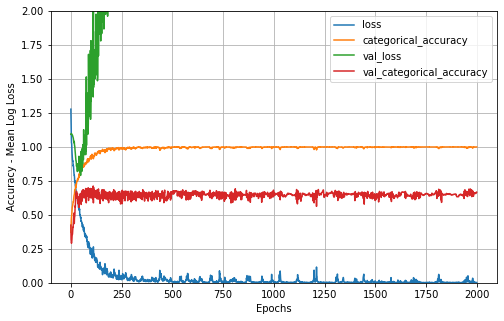

In [22]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

# categorical_accuracy es el training accuracy
# val_categorical_accuracy es el validation accuracy
# loss es el training loss
# val_loss es el validation loss

# Overfitting:
# Por un lado la Accuracy de los datos de entrenamiento aumenta con las epochs,
# mientras que la Accuracy de los datos de validación disminuye o se mantiene constante a lo largo de las epochs. 
# La Loss de los datos de validación alcanza su mínimo después de pocos epochs y luego empieza a subir, 
# mientras que la Loss de los datos de entrenamiento disminuye linealmente.

In [23]:
history.params

{'verbose': 1, 'epochs': 2000, 'steps': 8}

In [24]:
results[-1:]

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
1999,0.001944,0.999456,3.757421,0.667026


In [25]:
print ("Accuracy for the training set: ", results.categorical_accuracy.values[-1:][0])

Accuracy for the training set:  0.9994556307792664


In [26]:
print ("Accuracy for the development test set: ", results.val_categorical_accuracy.values[-1:][0])

Accuracy for the development test set:  0.6670258641242981


#### Let's see how the model predicts using the development test set:

In [27]:
dev_predictions=model.predict(X_dev).round(2) 
dev_predictions[:20]

array([[[1.  , 0.  , 0.  ]],

       [[1.  , 0.  , 0.  ]],

       [[1.  , 0.  , 0.  ]],

       [[0.92, 0.  , 0.08]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 1.  ]],

       [[0.  , 0.02, 0.98]],

       [[0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 1.  ]],

       [[1.  , 0.  , 0.  ]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 1.  , 0.  ]],

       [[0.  , 1.  , 0.  ]]], dtype=float32)

In [28]:
dev_predictions[:,0,:][:20]

array([[1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.92, 0.  , 0.08],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.02, 0.98],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ]], dtype=float32)

In [29]:
dev_rounded_predictions=np.round(dev_predictions[:,0,:])
indices = np.argmax(dev_predictions[:,0,:],1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [30]:
y_dev[:20, 0, :]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [31]:
dev_correct_predictions = np.equal(np.argmax(dev_predictions [:,0,:],1),np.argmax(y_dev[:,0,:],1))
print (dev_correct_predictions[:20])

[False False False False  True  True  True False False False False False
 False False False False False  True  True  True]


In [32]:
from collections import Counter
Counter(dev_correct_predictions)

Counter({False: 309, True: 619})

### 9. Save model

We save the model if it is better than others 

In [33]:
# Save
#model.save('EGG_prac1_ANN_model1.h5') # Change the name in each model

In [34]:
# Extract
"""
new_model = keras.models.load_model('path_to_my_model3.h5')

import numpy as np

# Verify state
new_predictions = new_model.predict(x_test)
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

# Note that the optimizer state is also preserved:
# you can resume training where you left off.
"""

"\nnew_model = keras.models.load_model('path_to_my_model3.h5')\n\nimport numpy as np\n\n# Verify state\nnew_predictions = new_model.predict(x_test)\nnp.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)\n\n# Note that the optimizer state is also preserved:\n# you can resume training where you left off.\n"

### 10 - Final Test

#### 10.1 - Load the final test set

In [35]:
"""
n_final_test = n_instances-n_train-n_dev

x_final_test = attributes.values[n_train+n_dev:n_instances]
t_final_test = label.values[n_train+n_dev:n_instances]

print ("x_test:",x_final_test.shape)
print ("t_test:",t_final_test.shape)


"""

'\nn_final_test = n_instances-n_train-n_dev\n\nx_final_test = attributes.values[n_train+n_dev:n_instances]\nt_final_test = label.values[n_train+n_dev:n_instances]\n\nprint ("x_test:",x_final_test.shape)\nprint ("t_test:",t_final_test.shape)\n\n\n'

#### 10.2 - Evaluate the model

In [33]:
from collections import Counter
def predictWithModel(model, X_test, y_test, task1, task2, task3=""):
    model.evaluate(X_test, y_test)
    test_predictions = model.predict(X_test)
    test_rounded_predictions=np.round(test_predictions)
    indices = np.argmax(test_predictions,1)
    for row, index in zip(test_rounded_predictions, indices): row[index]=1
    print(test_rounded_predictions[:20])
    
    # ACCURACY:
    test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(y_test,1))
    
    print()
    print(test_correct_predictions)
    print(type(test_correct_predictions))
    final_test_prediction_results=Counter(test_correct_predictions)
    
    success = np.mean(test_rounded_predictions == y_test)*100
    
    return final_test_prediction_results, success

In [34]:
users = ["0091"]
for u in users:   
    print("USER:", u)
    #X_test, y_test = readRegisterAndReturnXy(u, total_records, 122, 123, 127)
    accuracy, success = predictWithModel(model, X_test, y_test, 122, 123, 127)
    print(u, accuracy, success)
    print()

USER: 0091
29/29 [==============================] - 0s 997us/step - loss: 3.8825 - categorical_accuracy: 0.6344
[[[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]

 [[1. 1. 1.]]]

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 ...
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]
<class 'numpy.ndarray'>


TypeError: unhashable type: 'numpy.ndarray'

In [36]:
#model.evaluate(x_final_test, t_final_test) # Un 77 es un accuracy bajo 

The outputs computed by the neural network for the final testing dataset.

In [37]:
"""
test_predictions=model.predict(x_final_test)
test_rounded_predictions=np.round(test_predictions)
indices = np.argmax(test_predictions,1)
for row, index in zip(test_rounded_predictions, indices): row[index]=1
test_rounded_predictions[:20]
"""

'\ntest_predictions=model.predict(x_final_test)\ntest_rounded_predictions=np.round(test_predictions)\nindices = np.argmax(test_predictions,1)\nfor row, index in zip(test_rounded_predictions, indices): row[index]=1\ntest_rounded_predictions[:20]\n'

The target outputs.

In [38]:
# t_final_test[:20]

The first 30 predictions. True means that the neural network correctly classifies the input vector.

In [39]:
# test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(t_final_test,1))
# test_correct_predictions[:30]

#### The final test accuracy.

In [40]:
"""from collections import Counter
final_test_prediction_results=Counter(test_correct_predictions)
final_test_prediction_results"""

'from collections import Counter\nfinal_test_prediction_results=Counter(test_correct_predictions)\nfinal_test_prediction_results'

In [41]:
#final_test_prediction_results[True]/sum(final_test_prediction_results.values())